# Yoga Pose Detection using Machine Learning

![SegmentLocal](yoga-poses.gif "segment")

<h2> Introduction</h2>

> Pose detection techniques play vital role in computer vision to capture different body postures, which can be beneficial for various purposes, such as monitoring health, video-surveillance, human-computer interaction, sports analysis, etc,
Yoga is one such domain, where pose detection can help a lot by identifying correct postures.
In a way, it can assist person doing yoga to evaluate, whether he/she is doing a correct posture or not.
In this project, we have leveraged pose estimation and machine learning techniques to detect different yoga poses.


<h2> Problems and Challenges</h2>

>-	Correct Posture can cause detrimental consequences to body.
>-  Incorrect posture can be unproductive and wastes time.
>-  Unaffordability of instructor.
>-  Less data and low computational power to train the models


<h2> Literature Review</h2>

>- Apart from yoga pose detection, our research also revolves around comparative performance analysis of different machine learning and deep learning techniques on pose estimation data.
>- The factors it considers for comparison are less data and low computational resources.
>- Now, the question arrives, how it differs from other papers?
Here, literature review helped us identify the problem and different approaches used by different authors in past.


<h2> Media Pipe</h2>

> MediaPipe is an open-source framework working on multiple platforms.
It is an ML methodology for high fidelity posture tracking.
For key points creation, MediaPipe uses a two stage ML pipeline.
MediaPipe was chosen over OpenPose as it is faster. Medipipe can run efficiently on CPU. MediaPipe also allowed us to use <b>33 keypoints</b>, resulting in more features that leads to better prediction.

>It utilizes a two-step machine learning pipeline, by using a detector it first localizes the person within the frame and then uses the pose landmarks detector to predict the landmarks within the region of interest.

<img src='https://drive.google.com/uc?export=download&id=1c1vFXlRbN9r4ONKIE3sEmaLsWEfm2vpF'>

>For the videos, the detector is used only for the very first frame and then the ROI is derived from the previous frame’s pose landmarks using a tracking method. Also when the tracker loses track of the identify body pose presence in a frame, the detector is invoked again for the next frame which reduces the computation and latency. The image below shows the thirty-three pose landmarks along with their indexes.

<img src="https://drive.google.com/uc?export=download&id=1CDO0KiXZEOuWc7xLEm7EFLLQf2hydCoI">

<h3>Import Libraries</h3>

In [41]:
import math
import cv2
import numpy as np
import pandas as pd
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,recall_score,precision_score,f1_score,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from keras.models import Sequential
import pickle

In [ ]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import img_to_array
import os

<h3>Data Augmentation</h3>

In [ ]:
# Reading an image in default mode
src = cv2.imread('media/yoga.jpg')
  
# Window name in which image is displayed
window_name = 'Image'
  
# Using cv2.flip() method
# Use Flip code 0 to flip vertically
image = cv2.flip(src, 1)
  
# Displaying the image
cv2.imshow(window_name, image)

<h3>Initialize Pose Detection Model</h3>

In [42]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

<h3>Read an image with landmarks</h3>

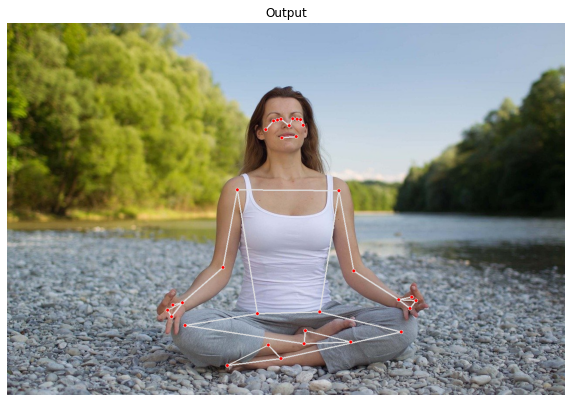

NOSE:
x: 0.5055418610572815
y: 0.2756081819534302
z: -0.196332186460495
visibility: 0.9999922513961792

LEFT_EYE_INNER:
x: 0.5122931599617004
y: 0.257201611995697
z: -0.1665937602519989
visibility: 0.9999876022338867

LEFT_EYE:
x: 0.5198646783828735
y: 0.2583414316177368
z: -0.16680176556110382
visibility: 0.9999853372573853

LEFT_EYE_OUTER:
x: 0.5258001685142517
y: 0.2595551013946533
z: -0.166790172457695
visibility: 0.9999884366989136

RIGHT_EYE_INNER:
x: 0.4909650385379791
y: 0.25824397802352905
z: -0.1704181432723999
visibility: 0.9999935626983643



In [10]:
# Read an image from the specified path.
sample_img = cv2.imread('media/yoga.jpg')

# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(5):
        
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

>- X Coordinate represents normalized [0,1] form width.
>- Y Coordinate represents normalized [0,1] form Height.
>- Z Coordinate represents normalized [0,1] distance of an object from camera.

> <b>Now, as we know how to extract coordinates of each landmark or keypoint, we will extract as coordinates for all images and prepare a dataset with 99 features. Later on, which will be used for model training. </b>

<h3> Feature extraction</h3>

In [ ]:
# create dataframe to store coordinates
data=pd.DataFrame() 

# Following code reads all the images from of a yoga pose, extracts 99 coordinates and append into dataframe to create a dataset
path_jfif = glob.glob('C:/Users/Dell/Downloads/Introduction to Pose Detection and Pose Classification/yoga poses/vrikshsana/*.jpg')
for file in path_jfif:
    sample_img = cv2.imread(file)
    
    # Perform pose detection after converting the image into RGB format.
    results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

  

    list_points=[]

    for i in range(33):
        list_points.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x)
        list_points.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y)
        list_points.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z)
        
    list1=[]
    list1.append(list_points)
    data = data.append(pd.DataFrame(list1),ignore_index=True)

>Given below is a snapshot of data that we prepared after extraction of coordinates. 

<img src='Snapshot of data.PNG'>

In [ ]:
# labels
list_bh=[0 for i in range(0,281)]
list_pd=[1 for i in range(281,379)]
list_sv=[2 for i in range(379,621)]
list_td=[3 for i in range(621,754)]
list_tr=[4 for i in range(754,920)]
list_vr=[5 for i in range(920,1096)]



>Given below is a snapshot of labels of poses.
<img src='Snapshot of label.PNG'>

<h2>Train Test Split</h2>


In [10]:
X=pd.read_csv('pose_cordinates.csv')
y=pd.read_csv('label.csv')

X.drop(['Unnamed: 0'],axis=1,inplace=True)
y.drop(['Unnamed: 0'],axis=1,inplace=True)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

<h2> Model training</h2> 

In [12]:
# Evaluation function
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

<h3> Logistic Regression</h3>

In [13]:
logistic = LogisticRegression()
logistic = logistic.fit(X_train,y_train)

C:\Users\Dell\anaconda3\envs\Pose_Estimation_Mediapipe\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dell\anaconda3\envs\Pose_Estimation_Mediapipe\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
y_train_pred = logistic.predict(X_train)
print_score(y_train, y_train_pred, train=True)

Train Result:
Accuracy Score: 94.98%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1           2           3           4  \
precision    0.978448   1.000000    0.948718    0.954023    0.925926   
recall       0.965957   0.987952    0.953608    0.821782    0.954198   
f1-score     0.972163   0.993939    0.951157    0.882979    0.939850   
support    235.000000  83.000000  194.000000  101.000000  131.000000   

                    5  accuracy   macro avg  weighted avg  
precision    0.896552  0.949772    0.950611      0.950895  
recall       0.984848  0.949772    0.944724      0.949772  
f1-score     0.938628  0.949772    0.946453      0.949406  
support    132.000000  0.949772  876.000000    876.000000  
_______________________________________________
Confusion Matrix: 
 [[227   0   6   0   2   0]
 [  0  82   0   0   0   1]
 [  5   0 185   2   2   0]
 [  0   0   0  83   5  13]
 [  0   0   3   2 125   1]
 [  0   0   1   0   1 130]]


In [15]:
y_test_pred = logistic.predict(X_test)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 91.82%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2          3          4          5  \
precision   0.938776   0.933333   0.975610   0.903226   0.842105   0.913043   
recall      1.000000   0.933333   0.833333   0.875000   0.914286   0.954545   
f1-score    0.968421   0.933333   0.898876   0.888889   0.876712   0.933333   
support    46.000000  15.000000  48.000000  32.000000  35.000000  44.000000   

           accuracy   macro avg  weighted avg  
precision  0.918182    0.917682      0.920744  
recall     0.918182    0.918416      0.918182  
f1-score   0.918182    0.916594      0.917679  
support    0.918182  220.000000    220.000000  
_______________________________________________
Confusion Matrix: 
 [[46  0  0  0  0  0]
 [ 0 14  0  0  0  1]
 [ 2  0 40  2  4  0]
 [ 0  0  0 28  1  3]
 [ 1  0  1  1 32  0]
 [ 0  1  0  0  1 42]]



<h3>Support Vector Machine</h3>

In [18]:
# Building a Support vector machine model
SVM = svm.SVC()
SVM = SVM.fit(X_train,y_train)

C:\Users\Dell\anaconda3\envs\Pose_Estimation_Mediapipe\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
y_train_pred = SVM.predict(X_train)
print_score(y_train, y_train_pred, train=True)

Train Result:
Accuracy Score: 95.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1           2           3           4  \
precision    0.995726   1.000000    0.989796    0.971831    0.954887   
recall       0.991489   0.975904    1.000000    0.683168    0.969466   
f1-score     0.993603   0.987805    0.994872    0.802326    0.962121   
support    235.000000  83.000000  194.000000  101.000000  131.000000   

                    5  accuracy   macro avg  weighted avg  
precision    0.819876  0.954338    0.955353      0.959458  
recall       1.000000  0.954338    0.936671      0.954338  
f1-score     0.901024  0.954338    0.940292      0.952623  
support    132.000000  0.954338  876.000000    876.000000  
_______________________________________________
Confusion Matrix: 
 [[233   0   1   0   1   0]
 [  0  81   1   0   0   1]
 [  0   0 194   0   0   0]
 [  0   0   0  69   5  27]
 [  1   0   0   2 127   1]
 [  0   0   0   0   0 132]]


In [21]:
y_test_pred = SVM.predict(X_test)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 95.00%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2          3          4          5  \
precision   0.978723   1.000000   1.000000   0.962963   0.916667   0.877551   
recall      1.000000   0.933333   0.979167   0.812500   0.942857   0.977273   
f1-score    0.989247   0.965517   0.989474   0.881356   0.929577   0.924731   
support    46.000000  15.000000  48.000000  32.000000  35.000000  44.000000   

           accuracy   macro avg  weighted avg  
precision      0.95    0.955984      0.952417  
recall         0.95    0.940855      0.950000  
f1-score       0.95    0.946650      0.949589  
support        0.95  220.000000    220.000000  
_______________________________________________
Confusion Matrix: 
 [[46  0  0  0  0  0]
 [ 0 14  0  0  0  1]
 [ 0  0 47  0  1  0]
 [ 0  0  0 26  1  5]
 [ 1  0  0  1 33  0]
 [ 0  0  0  0  1 43]]



<h3>Decision Tree</h3>

In [23]:
# Building a Decision Tree model
Decisiontree = DecisionTreeClassifier()
Decisiontree = Decisiontree.fit(X_train,y_train)

In [24]:
y_train_pred = Decisiontree.predict(X_train)
print_score(y_train, y_train_pred, train=True)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1      2      3      4      5  accuracy  macro avg  \
precision    1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
recall       1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
f1-score     1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
support    235.0  83.0  194.0  101.0  131.0  132.0       1.0      876.0   

           weighted avg  
precision           1.0  
recall              1.0  
f1-score            1.0  
support           876.0  
_______________________________________________
Confusion Matrix: 
 [[235   0   0   0   0   0]
 [  0  83   0   0   0   0]
 [  0   0 194   0   0   0]
 [  0   0   0 101   0   0]
 [  0   0   0   0 131   0]
 [  0   0   0   0   0 132]]



In [25]:
y_test_pred = Decisiontree.predict(X_test)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 87.27%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2          3          4          5  \
precision   0.956522   0.866667   0.911111   0.823529   0.815789   0.833333   
recall      0.956522   0.866667   0.854167   0.875000   0.885714   0.795455   
f1-score    0.956522   0.866667   0.881720   0.848485   0.849315   0.813953   
support    46.000000  15.000000  48.000000  32.000000  35.000000  44.000000   

           accuracy   macro avg  weighted avg  
precision  0.872727    0.867825      0.874116  
recall     0.872727    0.872254      0.872727  
f1-score   0.872727    0.869444      0.872791  
support    0.872727  220.000000    220.000000  
_______________________________________________
Confusion Matrix: 
 [[44  0  2  0  0  0]
 [ 0 13  0  1  0  1]
 [ 1  2 41  1  2  1]
 [ 0  0  0 28  0  4]
 [ 1  0  2  0 31  1]
 [ 0  0  0  4  5 35]]



<h3>Random Forest</h3>

In [26]:
# Building a random forest 
randomforest = RandomForestClassifier()
randomforest = randomforest.fit(X_train,y_train)

C:\Users\Dell\AppData\Local\Temp/ipykernel_23416/3164225349.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomforest = randomforest.fit(X_train,y_train)


In [27]:
y_train_pred = randomforest.predict(X_train)
print_score(y_train, y_train_pred, train=True)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1      2      3      4      5  accuracy  macro avg  \
precision    1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
recall       1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
f1-score     1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
support    235.0  83.0  194.0  101.0  131.0  132.0       1.0      876.0   

           weighted avg  
precision           1.0  
recall              1.0  
f1-score            1.0  
support           876.0  
_______________________________________________
Confusion Matrix: 
 [[235   0   0   0   0   0]
 [  0  83   0   0   0   0]
 [  0   0 194   0   0   0]
 [  0   0   0 101   0   0]
 [  0   0   0   0 131   0]
 [  0   0   0   0   0 132]]



In [28]:
y_test_pred = randomforest.predict(X_test)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 94.09%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2          3          4          5  \
precision   0.958333   1.000000   0.940000   0.966667   0.911765   0.913043   
recall      1.000000   0.800000   0.979167   0.906250   0.885714   0.954545   
f1-score    0.978723   0.888889   0.959184   0.935484   0.898551   0.933333   
support    46.000000  15.000000  48.000000  32.000000  35.000000  44.000000   

           accuracy   macro avg  weighted avg  
precision  0.940909    0.948301      0.941920  
recall     0.940909    0.920946      0.940909  
f1-score   0.940909    0.932361      0.940213  
support    0.940909  220.000000    220.000000  
_______________________________________________
Confusion Matrix: 
 [[46  0  0  0  0  0]
 [ 0 12  1  0  0  2]
 [ 1  0 47  0  0  0]
 [ 0  0  0 29  1  2]
 [ 1  0  2  1 31  0]
 [ 0  0  0  0  2 42]]



<h3>Gradient Boosting</h3>

In [30]:
# Building a Gradient boosting model
gradientboosting = GradientBoostingClassifier()
gradientboosting = gradientboosting.fit(X_train,y_train)

C:\Users\Dell\anaconda3\envs\Pose_Estimation_Mediapipe\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
# Evaluate Performance on Train data
y_train_pred = gradientboosting.predict(X_train)
print_score(y_train, y_train_pred, train=True)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1      2      3      4      5  accuracy  macro avg  \
precision    1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
recall       1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
f1-score     1.0   1.0    1.0    1.0    1.0    1.0       1.0        1.0   
support    235.0  83.0  194.0  101.0  131.0  132.0       1.0      876.0   

           weighted avg  
precision           1.0  
recall              1.0  
f1-score            1.0  
support           876.0  
_______________________________________________
Confusion Matrix: 
 [[235   0   0   0   0   0]
 [  0  83   0   0   0   0]
 [  0   0 194   0   0   0]
 [  0   0   0 101   0   0]
 [  0   0   0   0 131   0]
 [  0   0   0   0   0 132]]



In [32]:
# Predict on test data
# Evaluate Performance on Test data
y_test_pred = gradientboosting.predict(X_test)
print_score(y_test, y_test_pred, train=False)

Test Result:
Accuracy Score: 96.82%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1          2          3          4          5  \
precision   0.958333   1.0   1.000000   0.935484   0.970588   0.956522   
recall      1.000000   1.0   0.958333   0.906250   0.942857   1.000000   
f1-score    0.978723   1.0   0.978723   0.920635   0.956522   0.977778   
support    46.000000  15.0  48.000000  32.000000  35.000000  44.000000   

           accuracy   macro avg  weighted avg  
precision  0.968182    0.970155      0.968529  
recall     0.968182    0.967907      0.968182  
f1-score   0.968182    0.968730      0.968004  
support    0.968182  220.000000    220.000000  
_______________________________________________
Confusion Matrix: 
 [[46  0  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0  0 46  1  1  0]
 [ 1  0  0 29  0  2]
 [ 1  0  0  1 33  0]
 [ 0  0  0  0  0 44]]



<h3>Hyperparameter Tuning on gradient boosting</h3>

In [ ]:

# Number of trees in random forest
n_estimators = [50,100,150,200]
# Learning rate
learning_rate = [0.001,0.1,0.1,1]
# Maximum number of levels in tree
max_depth = [2,3,4,5]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4,5]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
grad_cv=RandomizedSearchCV(estimator=gradientboosting,param_distributions=random_grid,n_iter=100,cv=5,verbose=2,n_jobs=-1)

In [ ]:
### fit the randomized model
grad_cv.fit(X_train,y_train)

In [ ]:
# Provides best parameters
grad_cv.best_params_

<h3>Neural Network</h3>

In [ ]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 99, kernel_initializer = 'he_normal',activation='relu',input_dim = 99))

# Adding the second hidden layer
classifier.add(Dense(units = 70, kernel_initializer = 'he_normal',activation='relu'))
classifier.add(Dropout(0.2))

# Adding the second hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_normal',activation='relu'))
classifier.add(Dropout(0.2))

# Adding the second hidden layer
classifier.add(Dense(units = 20, kernel_initializer = 'he_normal',activation='relu'))
classifier.add(Dropout(0.2))

# Adding the output layer
classifier.add(Dense(units= 1, kernel_initializer = 'glorot_uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
model_history=classifier.fit(X, y, batch_size = 20, epochs = 100)

<h3>Convolutional Neural Network</h3>

In [ ]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (256, 256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
# Step 3 - Convolution
classifier.add(Conv2D(32, (3, 3),  activation = 'relu'))

# Adding a second Pooling layer
# Step 4 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
# Step 5 - Convolution
classifier.add(Conv2D(32, (3, 3),  activation = 'relu'))

# Adding a third Pooling layer
# Step 6 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 7 - Flattening
classifier.add(Flatten())

# Step 8 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))

classifier.add(Dropout(0.3))

# Step 9 - Output layer
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

# Generating train and test Dataset
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# File path
path1 = '/content/drive/MyDrive/Pose detection/CNN/Data/Train'
path2 = '/content/drive/MyDrive/Pose detection/CNN/Data/Test'

# Procesing images before training 
training_set = train_datagen.flow_from_directory(path1,
                                                 target_size = (256, 256),
                                                 batch_size = 10,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(path2,
                                            target_size = (256, 256),
                                            batch_size = 10,
                                            class_mode = 'binary')

# Model Fit
model = classifier.fit_generator(training_set,
                         steps_per_epoch = 112,
                         epochs = 10,
                         validation_data = test_set,    
                         validation_steps = 15)

<h3>Save and Load Model</h3>

In [39]:
#from sklearn.externals import joblib
 
# Save the model as a pickle in a file
#joblib.dump(gradientboosting, 'model_pkl.pkl')
 
import pickle 
with open('model_pkl' , 'rb') as f:
    gradboost = pickle.load(f)

<h3>Prediction on Images</h3>

In [45]:
# Read an image from the specified path.
sample_img = cv2.imread('media/Tadasana.jpg')

# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

list_points=[]
for i in range(33):
    list_points.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x)
    list_points.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y)
    list_points.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z)

my_array = [list_points]

r = gradboost.predict(my_array)

prob = gradboost.predict_proba(my_array)

pred=r[0]

probability = prob[0][pred]

probability = '{0:.3g}'.format(probability)

label=""
if pred==0:
    label="Bhujangasana"
elif pred==1:
    label="Padmasana"
elif pred==2:
    label="Shavasana"
elif pred==3:
    label="Tadasana"
elif pred==4:
    label="Trikonasana"
elif pred==5:
    label="Vrikshasana"
else:
    label="Unknown"
    

C:\Users\Dell\anaconda3\envs\Pose_Estimation_Mediapipe\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\envs\Pose_Estimation_Mediapipe\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


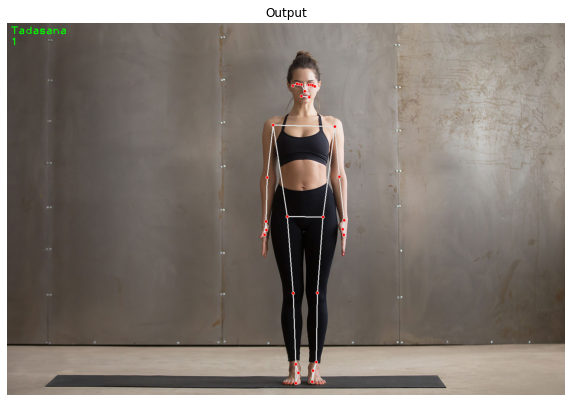

In [46]:
# Check if any landmarks are found.
if results.pose_landmarks:
    img_copy = sample_img.copy()
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    
    cv2.putText(img_copy, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    cv2.putText(img_copy, probability, (10, 60),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

<h3>Prediction on Videos</h3>

In [47]:
# keypoint Detection function
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    #imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(output_image)
    
    # Retrieve the height and width of the input image.
    height, width, _ = output_image.shape
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    

    for i in range(33):
        landmarks.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x)
        landmarks.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y)
        landmarks.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z)
    
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

In [49]:
# Detect pose function
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

    '''
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Prediction
    my_array = [landmarks]
    
    r = gradboost.predict(my_array)
    pred=r[0]
    
    prob = gradboost.predict_proba(my_array)
    
    probability = prob[0][pred]
    probability = '{0:.3g}'.format(probability)
    
    if pred==0:
        label="Bhujangasana"
    elif pred==1:
        label="Padmasana"
    elif pred==2:
        label="Shavasana"
    elif pred==3:
        label="Tadasana"
    elif pred==4:
        label="Trikonasana"
    elif pred==5:
        label="Vrikshasana"


    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    cv2.putText(output_image, probability, (10, 60),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label

In [ ]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture('Tadasana.mp4')
camera_video.set(3,1280)
camera_video.set(4,960)

# Initialize a resizable window.
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    #frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    # Check if the landmarks are detected.
    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    # Display the frame.
    cv2.imshow('Pose Detection', frame)
    
    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

<h2>References</h2>

>- Yadav, Santosh Kumar, Amitojdeep Singh, Abhishek Gupta, and Jagdish Lal Raheja. "Real-time Yoga recognition using deep learning." Neural Computing and Applications 31, no. 12 (2019): 9349-9361.
>- Palanimeera, J., and K. Ponmozhi. "Classification of yoga pose using machine learning techniques." Materials Today: Proceedings 37 (2021): 2930-2933.
>- Agrawal, Yash, Yash Shah, and Abhishek Sharma. "Implementation of machine learning technique for identification of yoga poses." In 2020 IEEE 9th International Conference on Communication Systems and Network Technologies (CSNT), pp. 40-43. IEEE, 2020.
>- Lai, A., B. Reddy, and B. Vlijmen. "Yog. ai: deep learning for yoga."
>- Kothari, Shruti. "Yoga Pose Classification Using Deep Learning." (2020).
>- mediapipe.com
>- BleedAi.com